# **Libraire et PIP**

In [179]:
!pip install tmm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [267]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import interpolate
from tmm import *
import cv2
from tqdm import tqdm
import itertools
import sys
import pandas as pd
import time
import scipy as sp
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans , Birch
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture

# **Fonction utile**

In [ ]:
def ellips_reverse(long_onde, dfilm):
    longonde = np.array(long_onde)
    n0 = np.array(ind_refracair)
    n1 = np.array(ind_refracrfilm)
    n2 = np.array(ind_refracrsub)

    num_layers = 3
    th_0 = np.array(np.deg2rad(60))

    th0 = sp.arcsin(n0*np.sin(th_0) / n0)
    th1 = sp.arcsin(n0*np.sin(th_0) / n1)
    th2 = sp.arcsin(n0*np.sin(th_0) / n2)

    kz0 = 2 * np.pi * n0 * np.cos(th0) / longonde
    kz1 = 2 * np.pi * n1 * np.cos(th1) / longonde
    kz2 = 2 * np.pi * n2 * np.cos(th2) / longonde

    delta0 = kz0 * np.inf
    delta1 = kz1 * dfilm
    delta2 = kz2 * np.inf

    rs0 = ((n0 * np.cos(th0) - n1 * np.cos(th1)) /
           (n0 * np.cos(th0) + n1 * np.cos(th1)))
    rs1 = ((n1 * np.cos(th1) - n2 * np.cos(th2)) /
           (n1 * np.cos(th1) + n2 * np.cos(th2)))
    ts0 = 2 * n0 * np.cos(th0) / (n0 * np.cos(th0) + n1 * np.cos(th1))
    ts1 = 2 * n1 * np.cos(th1) / (n1 * np.cos(th1) + n2 * np.cos(th2))
    rp0 = ((n1 * np.cos(th0) - n0 * np.cos(th1)) /
           (n1 * np.cos(th0) + n0 * np.cos(th1)))
    rp1 = ((n2 * np.cos(th1) - n1 * np.cos(th2)) /
           (n2 * np.cos(th1) + n1 * np.cos(th2)))
    tp0 = 2 * n0 * np.cos(th0) / (n1 * np.cos(th0) + n0 * np.cos(th1))
    tp1 = 2 * n1 * np.cos(th1) / (n2 * np.cos(th1) + n1 * np.cos(th2))

    S = []
    P = []

    for i in range(len(tp1)):
        S.append(np.zeros((2, 2), dtype=complex))
        S[i] = (1/ts1[i]) * np.dot(np.array([[np.exp(-1j*delta1[i]), 0], [0, np.exp(1j*delta1[i])]],
                                            dtype=complex), np.array([[1, rs1[i]], [rs1[i], 1]], dtype=complex))
        P.append(np.zeros((2, 2), dtype=complex))
        P[i] = (1/tp1[i]) * np.dot(np.array([[np.exp(-1j*delta1[i]), 0], [0, np.exp(1j*delta1[i])]],
                                            dtype=complex), np.array([[1, rp1[i]], [rp1[i], 1]], dtype=complex))

    Mtilde0 = make_2x2_array(1, 0, 0, 1, dtype=complex)
    Mtilde1S = []
    Mtilde2S = []
    Mtilde1P = []
    Mtilde2P = []
    rS = []
    rP = []

    delta = []
    psi = []
    for i in range(len(tp1)):
        Mtilde1S.append(np.dot(Mtilde0, S[i]))
        Mtilde2S.append(np.dot(make_2x2_array(1, rs0[i], rs0[i], 1,
                                              dtype=complex)/ts0[i], Mtilde1S[i]))
        Mtilde1P.append(np.dot(Mtilde0, P[i]))
        Mtilde2P.append(np.dot(make_2x2_array(1, rp0[i], rp0[i], 1,
                                              dtype=complex)/tp0[i], Mtilde1P[i]))
        rS.append(Mtilde2S[i][1, 0]/Mtilde2S[i][0, 0])
        rP.append(Mtilde2P[i][1, 0]/Mtilde2P[i][0, 0])
        psi.append(np.rad2deg((np.arctan(abs(rP[i]/rS[i])))))
        delta.append(np.rad2deg(np.angle(-rP[i]/rS[i])))
    return delta+psi

# **Data Generation**

Calcul des indices de réfraction :

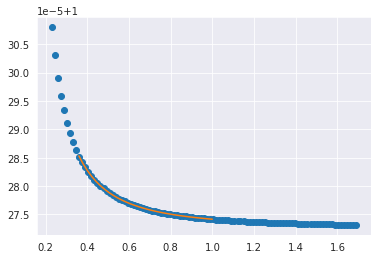

In [243]:
data1, data2, data3 = np.loadtxt('/content/sicr.nk') , np.loadtxt('/content/sio2.nk'), pd.read_csv('/content/air.csv', header = None)

x1, y1, z1 = data1 [:,0], data1 [:,1], data1 [:,2]  #substrat
x2, y2, z2 = data2 [:,0], data2 [:,1], data2 [:,2] 
x3, y3, z3 = data3 [0], data3 [1], np.zeros(len(data3[0]))

lambda_ = np.linspace(0.36,1.0,32)

f1 = interpolate.interp1d(x1, y1) 
f1i = interpolate.interp1d (x1, z1)
f2 = interpolate.interp1d(x2, y2)
f2i = interpolate.interp1d(x2, z2)
f3 = interpolate.interp1d(x3, y3)
f3i = interpolate.interp1d(x3, z3)

ind_refracrsub = []  
ind_refracrfilm = []
ind_refracair = []

for i in range (len(lambda_)):  #obtenir les indices de réfractions
  ind_refracrsub.append(complex(f1(lambda_[i]),f1i(lambda_[i])))
  ind_refracrfilm.append(complex(f2(lambda_[i]),f2i(lambda_[i])))
  ind_refracair.append(complex(f3(lambda_[i]),f3i(lambda_[i])))


plt.plot(x3, y3, 'o', lambda_, np.real(ind_refracair), '-') # verif
plt.show()

Passage de la photo en noir et blanc :

In [244]:
im_gray = cv2.imread('/content/pattern_tfe_petit.jpg', cv2.IMREAD_GRAYSCALE)

(thresh, im_bw) = cv2.threshold(im_gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

cv2.imwrite('/content/pattern_tfe_petit_BW.jpg', im_bw)

True

Génération des épaisseurs de la surface :

In [245]:
img=cv2.imread('/content/pattern_tfe_petit_BW.jpg',0)

def bruit (x) : 
    if x < 50 :
        return (round(100 + np.random.normal(0, 1.1, 1)[0], 3))
    else : 
        ep2 = round(5 + np.random.normal(0, 1.1, 1)[0],3)
        if ep2 < 0 : 
            print("Épaisseur <0, arrêt")
            sys.exit()
        else :
            return (ep2)

ep_bruit = list(map(bruit,list(itertools.chain(*img))))

pd.DataFrame(np.reshape(ep_bruit,img.shape)).to_csv('/content/epaisseur_bruit_grand.csv',index=False)

Calcul des Psi et des Delta pour chaque épaisseur :

In [246]:
angle = 60
long_onde = np.linspace(360,1000,32)  
   
def ellips2 (x) : 
       e_data = ellips(n_list, [inf, x, inf], np.deg2rad(angle), long_onde_use)        
       return (round(np.rad2deg(e_data['psi']),3),round(np.rad2deg(e_data['Delta']),3))
    
for k, value_lambda in tqdm(enumerate(long_onde)):
    bruit_copy = ep_bruit
    long_onde_use = value_lambda
    n_list = [ind_refracair[k],ind_refracrfilm[k],ind_refracrsub[k]]
    data = list(map(ellips2,bruit_copy))
    pd.DataFrame((np.reshape(list(zip(*data))[0],img.shape))).to_csv(f'/content/Psi/PSI_Si02_Sicr_{int(value_lambda)}_{angle}°.csv',index = False) 
    pd.DataFrame((np.reshape(list(zip(*data))[1],img.shape))).to_csv(f'/content/Delta/Delta_Si02_Sicr_{int(value_lambda)}_{angle}°.csv',index = False)   

32it [09:29, 17.79s/it]


# **non-real Data analysis**

Récupération des données :

In [35]:
recup_nbr_line = pd.read_csv('/content/Delta/Delta_Si02_Sicr_360_60°.csv').shape

long_onde = np.linspace(360,1000,32)

sns.set_style("darkgrid")

x =[[[] for i in range(recup_nbr_line[1])] for j in range(recup_nbr_line[0])]
y = [[[] for i in range(recup_nbr_line[1])] for j in range(recup_nbr_line[0])]
w = [[[] for i in range(recup_nbr_line[1])] for j in range(recup_nbr_line[0])]

for i in tqdm(range(len(long_onde))):
  recup_delta = pd.read_csv(f'/content/Delta/Delta_Si02_Sicr_{int(long_onde[i])}_60°.csv').to_numpy()
  recup_psi = pd.read_csv(f'/content/Psi/PSI_Si02_Sicr_{int(long_onde[i])}_60°.csv').to_numpy()
  for j in range(recup_psi.shape[0]):
    for k in range(recup_psi.shape[1]):
        x[j][k].append(recup_delta[j][k])
        y[j][k].append(recup_psi[j][k])
  if i == 0 :
      recup_ep = pd.read_csv('/content/epaisseur_bruit_grand.csv').to_numpy()
      for jj in range(recup_psi.shape[0]):
          for kk in range(recup_psi.shape[1]):
              w[jj][kk].append(recup_ep[jj][kk])

100%|██████████| 32/32 [00:02<00:00, 12.80it/s]


Mise sous forme de liste :

In [36]:
delta = list(itertools.chain(*x))
psi = list(itertools.chain(*y))
epaiseur = list(itertools.chain(*list(itertools.chain(*w))))

combine = np.array([delta[i] + psi[i] for i in range(len(delta))])

Visualisation des spectres :

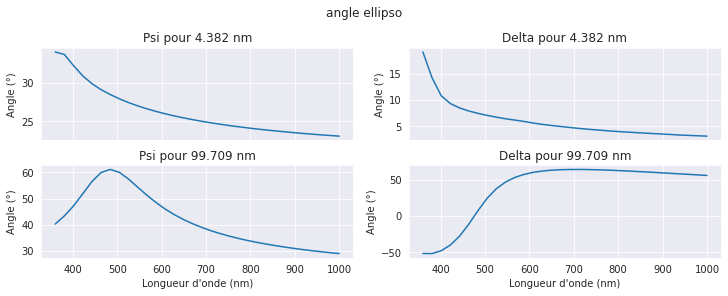

In [39]:
fig, axes = plt.subplots(2, 2,sharex=True,figsize=(10,4),constrained_layout=True)

fig.suptitle(f'angle ellipso')

sns.lineplot(ax=axes[0,0],x = long_onde,y = psi[51])
axes[0,0].set_title(f'Psi pour {epaiseur[51]} nm')
axes[0,0].set_xlabel('Longueur d\'onde (nm)')
axes[0,0].set_ylabel('Angle (°)')
sns.lineplot(ax=axes[0,1],x = long_onde,y = delta[51])
axes[0,1].set_title(f'Delta pour {epaiseur[51]} nm')
axes[0,1].set_xlabel('Longueur d\'onde (nm)')
axes[0,1].set_ylabel('Angle (°)')
sns.lineplot(ax=axes[1,0],x = long_onde,y = psi[15000])
axes[1,0].set_title(f'Psi pour {epaiseur[15000]} nm')
axes[1,0].set_xlabel('Longueur d\'onde (nm)')
axes[1,0].set_ylabel('Angle (°)')
sns.lineplot(ax=axes[1,1],x = long_onde,y = delta[15000])
axes[1,1].set_title(f'Delta pour {epaiseur[15000]} nm')
axes[1,1].set_xlabel('Longueur d\'onde (nm)')
axes[1,1].set_ylabel('Angle (°)')

plt.show()

Premier Clustering (voir si cela à un sens) :

In [42]:
kmeans = KMeans(n_clusters=256,random_state=0,n_init=3,max_iter=300,verbose = 0)
kmeans.fit(combine)

unique, counts = np.unique(kmeans.labels_, return_counts=True)
unique_count = dict(zip(unique, counts))

df = pd.DataFrame(combine)

df["classe"]=(list(kmeans.labels_))
df["epaiseur"]=epaiseur

In [43]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,classe,epaiseur
0,21.715,16.702,13.195,11.612,10.697,10.035,9.503,9.042,8.639,8.270,...,23.751,23.637,23.528,23.422,23.327,23.231,23.148,23.064,112,5.987
1,19.971,15.029,11.582,10.059,9.204,8.598,8.119,7.707,7.350,7.024,...,23.741,23.627,23.519,23.413,23.318,23.223,23.140,23.056,250,4.904
2,19.026,14.122,10.709,9.219,8.396,7.821,7.371,6.986,6.654,6.351,...,23.737,23.623,23.515,23.409,23.315,23.220,23.137,23.053,173,4.320
3,19.591,14.664,11.231,9.722,8.879,8.285,7.818,7.417,7.070,6.753,...,23.739,23.625,23.518,23.411,23.317,23.222,23.139,23.055,148,4.669
4,17.163,12.341,8.995,7.572,6.812,6.297,5.904,5.572,5.289,5.033,...,23.729,23.616,23.508,23.403,23.309,23.214,23.131,23.048,106,3.177


Moyenne sur les clusters :

In [44]:
spectre_mean = []
ep_classe = []

for i in tqdm(range(len(unique))):
  spectre_mean.append([])
  df_mask=df['classe']==i
  df2 = df[df_mask]
  ep_all = df2.pop('epaiseur')
  spectre_mean[i]=[df2[j].mean() for j in range(len(long_onde)*2)]
  ep_classe.append(round(ep_all.mean(),4))
        
df3 = pd.DataFrame(spectre_mean)

100%|██████████| 256/256 [00:05<00:00, 43.41it/s]


In [45]:
df3.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-51.597978,-51.421814,-47.119792,-38.850776,-26.249279,-9.507776,9.104284,25.819082,38.501410,47.352377,...,33.204743,32.568213,31.986268,31.451082,30.956995,30.497383,30.073301,29.677328,29.314164,28.969825
1,20.270168,15.315086,11.858111,10.324829,9.459214,8.843657,8.355650,7.935329,7.570389,7.236921,...,23.992000,23.863154,23.743000,23.629000,23.521000,23.414000,23.320000,23.224329,23.142000,23.058000
2,-51.206992,-52.631639,-50.021887,-43.591459,-33.128496,-18.354068,-0.283383,17.750564,32.500752,43.157459,...,33.729000,33.053940,32.438128,31.873113,31.352429,30.868970,30.423496,30.008301,29.627789,29.267489
3,18.530351,13.648131,10.252612,8.780604,7.974490,7.415033,6.980208,6.609114,6.290233,5.999820,...,23.983000,23.855000,23.734184,23.621000,23.513000,23.407000,23.313000,23.218000,23.135000,23.051686
4,-51.483303,-52.013697,-48.461896,-41.010827,-29.347087,-13.410476,5.088364,22.461563,36.041281,45.642545,...,33.427355,32.774584,32.178342,31.630649,31.125338,30.655610,30.222494,29.818346,29.447879,29.096762


Filtre pour récupérer les différentes parties de l'échantillon :

In [87]:
Filter = np.array([True if x < 40 else False for x in ep_classe ])

spectre_near_5 = list(np.array(spectre_mean)[Filter])
spectre_near_100 = list(np.array(spectre_mean)[~Filter])
ep_classe_near_5 = list(np.array(ep_classe)[Filter])
ep_classe_near_100 = list(np.array(ep_classe)[~Filter])

Visualisation avec la similarité cosinus :

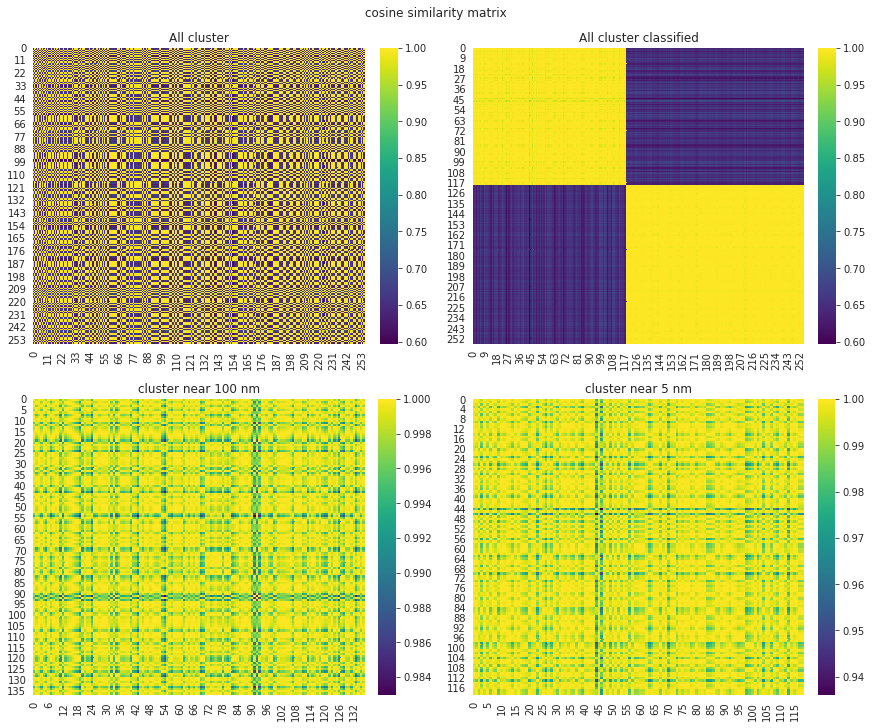

In [90]:
cosine_all = cosine_similarity(spectre_near_5+spectre_near_100)
cosine_5 = cosine_similarity(spectre_near_5)
cosine_100 = cosine_similarity(spectre_near_100)        
        
fig, axes = plt.subplots(2, 2,figsize=(12,10),constrained_layout=True)
fig.suptitle('cosine similarity matrix')

axes[0,0].set_title('All cluster')
axes[0,1].set_title('All cluster classified')
axes[1,0].set_title('cluster near 100 nm')
axes[1,1].set_title('cluster near 5 nm')
sns.heatmap(cosine_similarity(df3),cmap='viridis',ax=axes[0,0])
sns.heatmap(cosine_all,cmap='viridis',ax=axes[0,1])
sns.heatmap(cosine_100,cmap='viridis',ax=axes[1,0])
sns.heatmap(cosine_5,cmap='viridis',ax=axes[1,1])
plt.show()

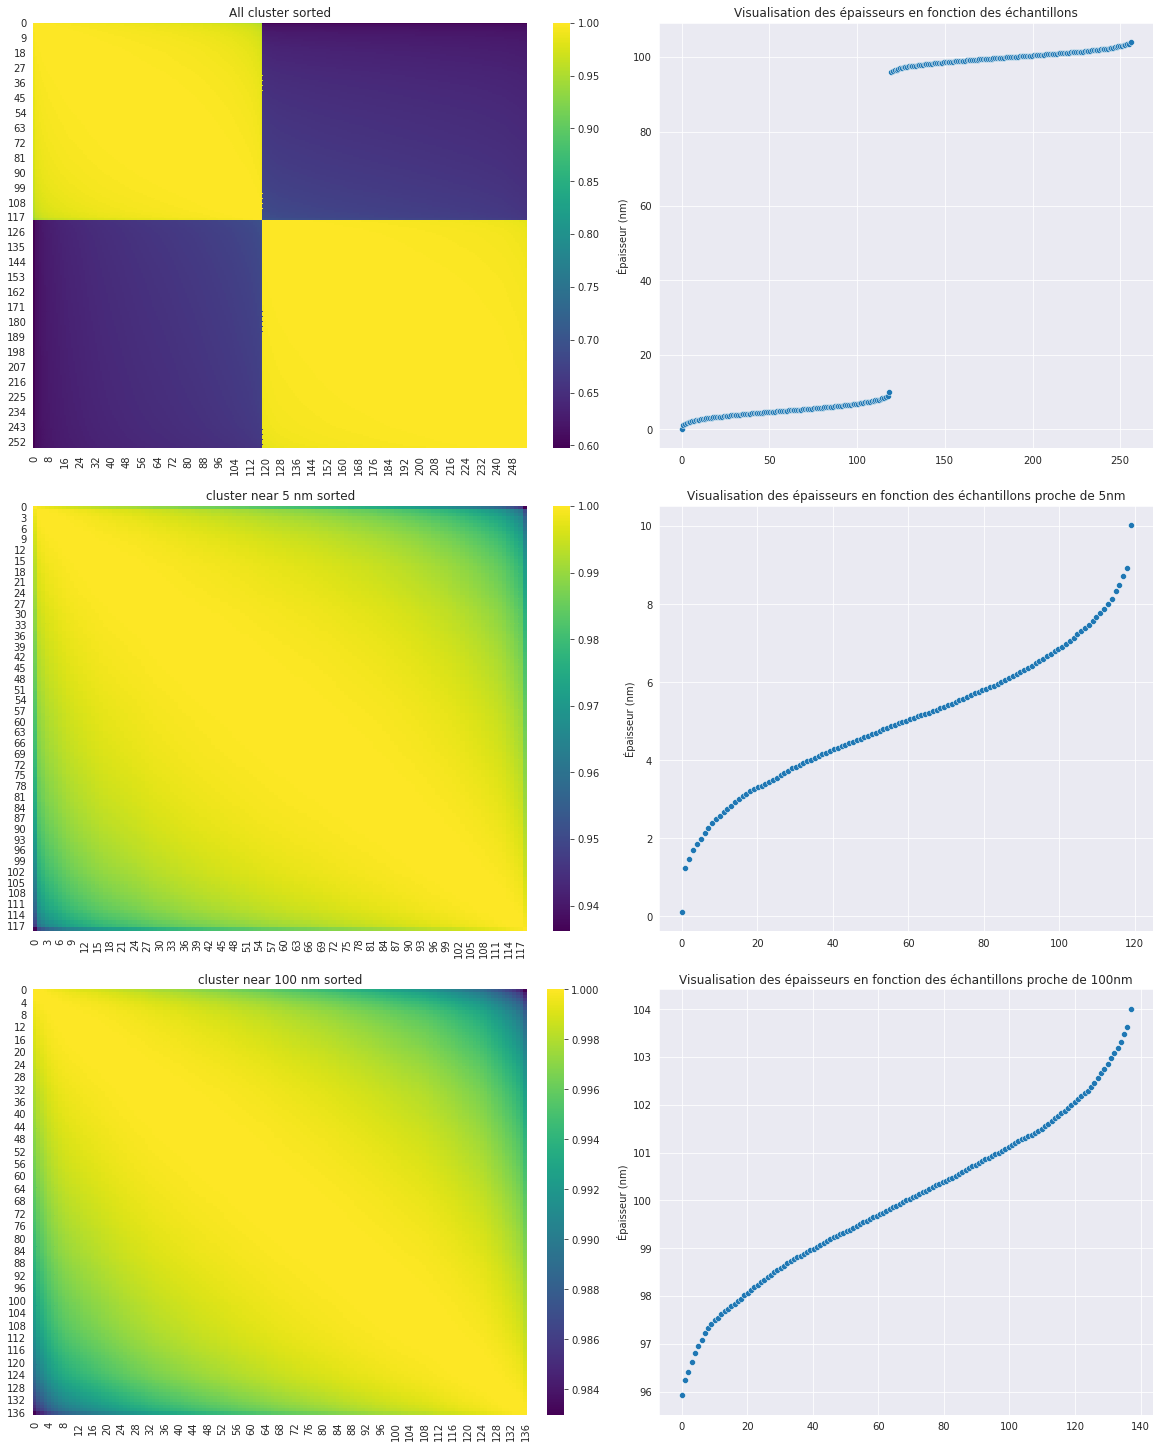

In [91]:
all_sorted = [i for _, i in sorted(zip(ep_classe_near_5+ep_classe_near_100,spectre_near_5+spectre_near_100))]
sorted_5 = [i for _, i in sorted(zip(ep_classe_near_5,spectre_near_5))]
sorted_100 =[i for _, i in sorted(zip(ep_classe_near_100,spectre_near_100))]

fig, axes = plt.subplots(3,2,figsize=(16,20),constrained_layout=True)

axes[0,0].set_title('All cluster sorted')
axes[0,1].set_title('Visualisation des épaisseurs en fonction des échantillons')
axes[0,1].set_ylabel('Épaisseur (nm)')
axes[1,0].set_title('cluster near 5 nm sorted')
axes[1,1].set_title('Visualisation des épaisseurs en fonction des échantillons proche de 5nm')
axes[1,1].set_ylabel('Épaisseur (nm)')
axes[2,0].set_title('cluster near 100 nm sorted')
axes[2,1].set_title('Visualisation des épaisseurs en fonction des échantillons proche de 100nm')
axes[2,1].set_ylabel('Épaisseur (nm)')
sns.heatmap(cosine_similarity(all_sorted),cmap='viridis',ax=axes[0,0])
sns.scatterplot(x = np.linspace(0,len(ep_classe_near_5+ep_classe_near_100),len(ep_classe_near_5+ep_classe_near_100)), y = sorted(ep_classe_near_5+ep_classe_near_100),ax=axes[0,1])
sns.heatmap(cosine_similarity(sorted_5),cmap='viridis',ax=axes[1,0])
sns.scatterplot(x = np.linspace(0,len(ep_classe_near_5),len(ep_classe_near_5)), y = sorted(ep_classe_near_5),ax=axes[1,1])
sns.heatmap(cosine_similarity(sorted_100),cmap='viridis',ax=axes[2,0])
sns.scatterplot(x = np.linspace(0,len(ep_classe_near_100),len(ep_classe_near_100)), y = sorted(ep_classe_near_100),ax=axes[2,1])

plt.show()

Visualisation par réduction de dimension (T-sne) :


In [92]:
tsne_em = TSNE(n_components=2, perplexity=20.0, n_iter=50000, verbose=0,random_state=0).fit_transform(df3)

x = [[],[]]
y=[[],[]]
z = [[],[]]
value = []

for i in range(len(tsne_em)):
  z[0].append(tsne_em[i][0])
  z[1].append(tsne_em[i][1])
  if ep_classe [i]< 25 :
      x[0].append(tsne_em[i][0])
      y[0].append(tsne_em[i][1])
  else :
      x[1].append(tsne_em[i][0])
      y[1].append(tsne_em[i][1])

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


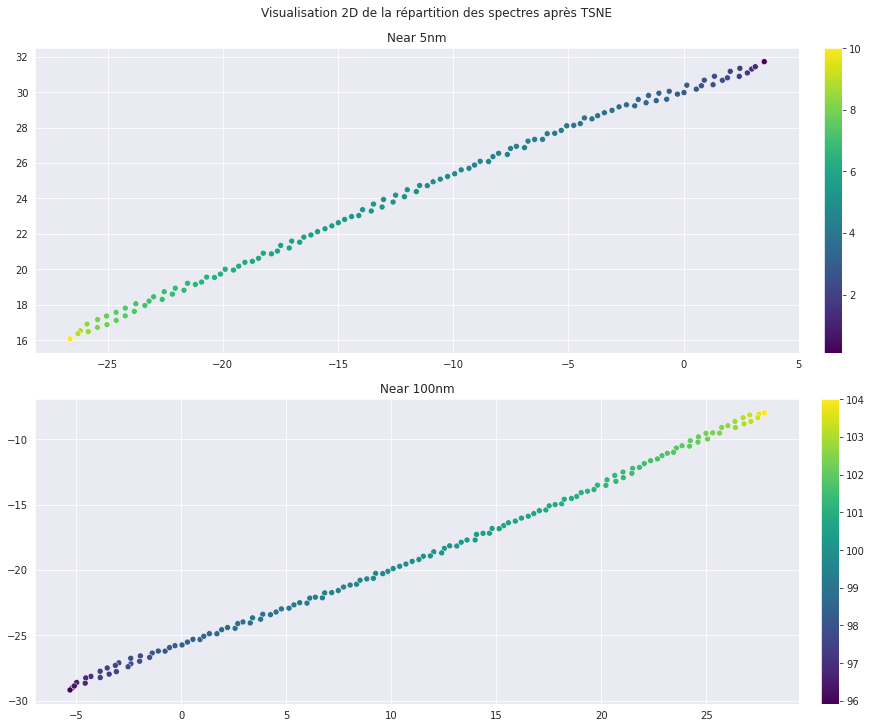

In [93]:
fig, axes = plt.subplots(2, 1,figsize=(12,10),constrained_layout=True)
fig.suptitle('Visualisation 2D de la répartition des spectres après TSNE')

sns.scatterplot(x = x[0], y = y[0],hue = ep_classe_near_5,palette='viridis',ax=axes[0])
norm1 = plt.Normalize(min(ep_classe_near_5), max(ep_classe_near_5))
sm1 = plt.cm.ScalarMappable(cmap="viridis", norm=norm1)
sm1.set_array([])
axes[0].get_legend().remove()
axes[0].figure.colorbar(sm1,ax = axes[0])
axes[0].set_title('Near 5nm')
sns.scatterplot(x = x[1], y = y[1],hue = ep_classe_near_100,palette='viridis',ax=axes[1])
norm2 = plt.Normalize(min(ep_classe_near_100), max(ep_classe_near_100))
sm2 = plt.cm.ScalarMappable(cmap="viridis", norm=norm2)
sm2.set_array([])
axes[1].get_legend().remove()
axes[1].figure.colorbar(sm2,ax = axes[1])
axes[1].set_title('Near 100nm')

plt.show()

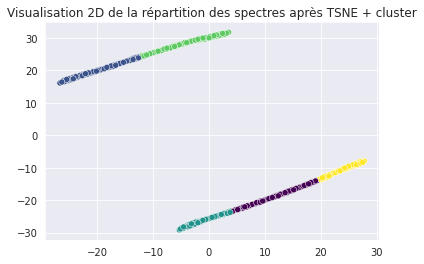

In [96]:
cluster = KMeans(n_clusters=5, random_state=0, verbose = 0)
cluster.fit_predict(df3)

sns.scatterplot(x = z[0],y =  z[1], c = cluster.labels_, cmap='viridis')
plt.title('Visualisation 2D de la répartition des spectres après TSNE + cluster')
plt.show()

# **Inversion sans clustering (long, 150 données pour l'exemple)**

Définition de la longueur d'onde, de l'angle ainsi que de la taille de l'échantillon :

In [248]:
long_onde = np.linspace(360, 1000, 32)
angle = 60
recup_nbr_line = pd.read_csv(
    '/content/Delta/Delta_Si02_Sicr_360_60°.csv').shape

Calcul des indices de réfraction :

In [249]:
data1, data2, data3 = np.loadtxt('/content/sicr.nk') , np.loadtxt('/content/sio2.nk'), pd.read_csv('/content/air.csv', header = None)

x1, y1, z1 = data1 [:,0], data1 [:,1], data1 [:,2]  #substrat
x2, y2, z2 = data2 [:,0], data2 [:,1], data2 [:,2] 
x3, y3, z3 = data3 [0], data3 [1], np.zeros(len(data3[0]))

lambda_ = np.linspace(0.36,1.0,32)

f1 = interpolate.interp1d(x1, y1) 
f1i = interpolate.interp1d (x1, z1)
f2 = interpolate.interp1d(x2, y2)
f2i = interpolate.interp1d(x2, z2)
f3 = interpolate.interp1d(x3, y3)
f3i = interpolate.interp1d(x3, z3)

ind_refracrsub = []  
ind_refracrfilm = []
ind_refracair = []

for i in range (len(lambda_)):  #obtenir les indices de réfractions
  ind_refracrsub.append(complex(f1(lambda_[i]),f1i(lambda_[i])))
  ind_refracrfilm.append(complex(f2(lambda_[i]),f2i(lambda_[i])))
  ind_refracair.append(complex(f3(lambda_[i]),f3i(lambda_[i])))

Récupération des données :

In [ ]:
x = [[[] for i in range(recup_nbr_line[1])]for j in range(recup_nbr_line[0])]
y = [[[] for i in range(recup_nbr_line[1])]for j in range(recup_nbr_line[0])]

for lambda_ in tqdm(long_onde):
            recup_delta = pd.read_csv(
                f'/content/Delta/Delta_Si02_Sicr_{int(lambda_)}_60°.csv').to_numpy()
            recup_psi = pd.read_csv(
                f'/content/Psi/PSI_Si02_Sicr_{int(lambda_)}_60°.csv').to_numpy()
            for j in range(recup_psi.shape[0]):
                for k in range(recup_psi.shape[1]):
                    x[j][k].append(recup_delta[j][k])
                    y[j][k].append(recup_psi[j][k])

delta = list(itertools.chain(*x))
psi = list(itertools.chain(*y))
combine = np.array([delta[i] + psi[i]for i in range(len(delta))])[:150]
df3 = pd.DataFrame(np.around(combine, 5))


Inversion sans clustering :

In [ ]:
epaisseur_fit = []
for i in tqdm(range(len(combine))):
            fit = sp.optimize.curve_fit(
                ellips_reverse, long_onde, combine[i], method='lm')
            epaisseur_fit.append(round(float(fit[0]), 5))

In [258]:
vrai = pd.read_csv('/content/epaisseur_bruit_grand.csv')

verif = np.array(vrai)[0][:150] - epaisseur_fit

print(verif)

[-7.0e-05  0.0e+00 -6.0e-05 -3.0e-05  1.0e-05  6.0e-05 -2.0e-05 -2.0e-05
  5.0e-05  1.0e-05  5.0e-05  0.0e+00 -4.0e-05 -9.0e-05  5.0e-05 -3.0e-05
 -4.0e-05  7.0e-05  5.0e-05  1.0e-05 -2.0e-05  0.0e+00  2.0e-05  0.0e+00
  1.0e-05  4.0e-05  2.0e-05 -2.0e-05 -1.0e-05  2.0e-05 -2.0e-05  2.0e-05
  1.2e-04  6.0e-05 -3.0e-05 -5.0e-05 -6.0e-05  5.0e-05  2.0e-05  0.0e+00
  2.0e-05  1.0e-05  2.0e-05 -2.0e-05 -7.0e-05 -1.0e-05  8.0e-05  7.0e-05
 -1.0e-05  0.0e+00  1.0e-05  8.0e-05 -1.1e-04  1.0e-05  6.0e-05 -5.0e-05
 -9.0e-05  3.0e-05  0.0e+00 -7.0e-05 -5.0e-05 -3.0e-05 -4.0e-05 -3.0e-05
 -3.0e-05 -6.0e-05 -4.0e-05  0.0e+00 -3.0e-05  7.0e-05 -3.0e-05  6.0e-05
 -3.0e-05  4.0e-05  7.0e-05  3.0e-05  1.0e-05  1.0e-05 -5.0e-05 -1.0e-04
 -6.0e-05 -2.0e-05  7.0e-05  7.0e-05 -3.0e-05  7.0e-05  3.0e-05  5.0e-05
  1.0e-05  6.0e-05 -4.0e-05 -5.0e-05 -6.0e-05 -1.0e-05 -1.0e-05 -1.1e-04
  4.0e-05  8.0e-05  1.0e-05  1.0e-04 -5.0e-05  3.0e-05  4.0e-05  2.0e-05
  6.0e-05  2.0e-05 -1.0e-05  6.0e-05  9.0e-05 -6.0e

# **Inversion avec clustering (2ème clustering pour l'accélération)**

Identique à la version sans clustering :

In [259]:
long_onde = np.linspace(360, 1000, 32)
angle = 60
recup_nbr_line = pd.read_csv(
    '/content/Delta/Delta_Si02_Sicr_360_60°.csv').shape

In [260]:
data1, data2, data3 = np.loadtxt('/content/sicr.nk') , np.loadtxt('/content/sio2.nk'), pd.read_csv('/content/air.csv', header = None)

x1, y1, z1 = data1 [:,0], data1 [:,1], data1 [:,2]  #substrat
x2, y2, z2 = data2 [:,0], data2 [:,1], data2 [:,2] 
x3, y3, z3 = data3 [0], data3 [1], np.zeros(len(data3[0]))

lambda_ = np.linspace(0.36,1.0,32)

f1 = interpolate.interp1d(x1, y1) 
f1i = interpolate.interp1d (x1, z1)
f2 = interpolate.interp1d(x2, y2)
f2i = interpolate.interp1d(x2, z2)
f3 = interpolate.interp1d(x3, y3)
f3i = interpolate.interp1d(x3, z3)

ind_refracrsub = []  
ind_refracrfilm = []
ind_refracair = []

for i in range (len(lambda_)):  #obtenir les indices de réfractions
  ind_refracrsub.append(complex(f1(lambda_[i]),f1i(lambda_[i])))
  ind_refracrfilm.append(complex(f2(lambda_[i]),f2i(lambda_[i])))
  ind_refracair.append(complex(f3(lambda_[i]),f3i(lambda_[i])))

In [261]:
x = [[[] for i in range(recup_nbr_line[1])]for j in range(recup_nbr_line[0])]
y = [[[] for i in range(recup_nbr_line[1])]for j in range(recup_nbr_line[0])]

for lambda_ in tqdm(long_onde):
            recup_delta = pd.read_csv(
                f'/content/Delta/Delta_Si02_Sicr_{int(lambda_)}_60°.csv').to_numpy()
            recup_psi = pd.read_csv(
                f'/content/Psi/PSI_Si02_Sicr_{int(lambda_)}_60°.csv').to_numpy()
            for j in range(recup_psi.shape[0]):
                for k in range(recup_psi.shape[1]):
                    x[j][k].append(recup_delta[j][k])
                    y[j][k].append(recup_psi[j][k])

delta = list(itertools.chain(*x))
psi = list(itertools.chain(*y))
combine = np.array([delta[i] + psi[i]for i in range(len(delta))])


100%|██████████| 32/32 [00:03<00:00,  8.26it/s]


Ajout du premier clustering pour réduire le nombre de spectre à analyser :

In [264]:
first_cluster = Birch(n_clusters=1024,
                              threshold=0.01).fit_predict(combine)

Application d'une moyenne en chaque point pour chaque cluster :

In [265]:
unique, counts = np.unique(first_cluster, return_counts=True)
df = pd.DataFrame(combine)
df["classe"] = (list(first_cluster))
spectre_mean = []
for i in range(len(unique)):
    spectre_mean.append([])
    df_mask = df['classe'] == unique[i]
    df2 = df[df_mask]
    spectre_mean[i] = [df2[j].mean() for j in range(len(long_onde)*2)]

    df3 = pd.DataFrame(np.around(spectre_mean, 5))

2ème clustering pour encore accélérer le temps de traitement :

In [268]:
cluster2 = GaussianMixture(n_components=2, random_state=0, verbose=1).fit_predict(combine, y=None)

Initialization 0
Initialization converged: True


Inversion des spectres pour récupérer les épaisseurs :

In [294]:
epaisseur_fit = []

first_1, first_2 = True, True

for i in tqdm(range(len(spectre_mean))):
        if cluster2[i]==0 : 
          if first_1 :
            fit = sp.optimize.curve_fit(ellips_reverse,long_onde,spectre_mean[i], method = 'lm')
            aide_fit1 = float(fit[0])
            first_1 = False
          else :
            fit = sp.optimize.curve_fit(ellips_reverse,long_onde,spectre_mean[i], method = 'lm', p0= aide_fit1)
        else : 
          if first_2 :
            fit = sp.optimize.curve_fit(ellips_reverse,long_onde,spectre_mean[i], method = 'lm')
            aide_fit2 = float(fit[0])
            first_2 = False
          else :
            fit = sp.optimize.curve_fit(ellips_reverse,long_onde,spectre_mean[i], method = 'lm',p0= aide_fit2)
        epaisseur_fit.append(round(float(fit[0]),5))  

  0%|          | 0/1024 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: scipy.arcsin is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.arcsin instead
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: scipy.arcsin is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.arcsin instead
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: scipy.arcsin is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.arcsin instead
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in multiply
100%|██████████| 1024/1024 [00:44<00:00, 23.00it/s]


Attribution des épaisseurs à chacun des points de l'échantillon :

In [295]:
new_ep = []
classe = first_cluster
for i in tqdm(range(len(classe))):
        new_ep.append(epaisseur_fit[classe[i]])

100%|██████████| 40320/40320 [00:00<00:00, 775654.22it/s]


Heatmap de l'échantillon ainsi que de l'erreur sur chaque pixel de ce dernier :

In [300]:
ep_clust = np.reshape(new_ep,recup_nbr_line )

vrai_ep = np.array(pd.read_csv('/content/epaisseur_bruit_grand.csv'))

Text(0.5, 1.0, 'Image en 2D de la surface après clustering')

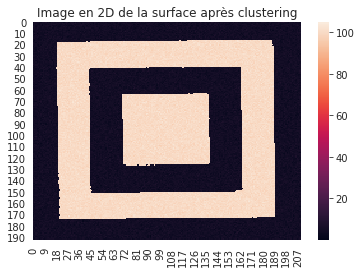

In [302]:
sns.heatmap(np.reshape(new_ep,recup_nbr_line ))
plt.title("Image en 2D de la surface après clustering")

Text(0.5, 1.0, "Heatmap des erreurs (nm) pour chaque pixel de l'image")

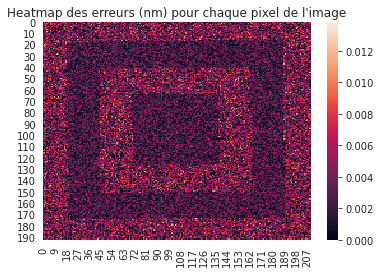

In [303]:
sns.heatmap(np.abs(ep_clust - vrai_ep))
plt.title("Heatmap des erreurs (nm) pour chaque pixel de l'image")